In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
### PANEL GŁÓWNY Numpy ### - Zmienne niezbędne dla wykonania zbioru danych przez Numpy biorą się stąd. 
# Szczegóły słabiej opisanych - zeszyt kursowy 1

observations = 1000  # Ustaw ilość obserwacji (Startowa: 1000)
vnum = 1             # Liczba zmiennych
noic = 10            # Szum w bazie przypadków treningowych.
noit = 1             # Szum wygenerowany dla funkcji testującej (docelowej).
model = [13,7,-12]   # Parametry modelu losowego dla funkcji a*xs + b*xz + c + szum.

#### 1. Tworzenie i składowanie danych

In [3]:
xs = np.random.uniform(low = -noic, high = noic, size =(observations,vnum)) # Gen. zakr. los. zm. wej.(patrz zeszyt 1)
zs = np.random.uniform(-noic,noic,(observations,vnum)) # J.w.- bez opisów bo zbędne. Poz. dla orientacji.

generated_inputs = np.column_stack((xs,zs)) # Składanie z pow. matrycy w formacie observationsx2. (Patrz zeszyt 1)

noise = np.random.uniform(-noit,noit,(observations,1)) # Gen. zakr. los. (Patrz zeszyt 1)

generated_targets = model[0]*xs + model[1]*zs + model[2] + noise # Funkcja symulująca zadane cele. Do niej dąży model. (Patrz zeszyt 1)

np.savez('My_Nums', inputs = generated_inputs, targets = generated_targets) # Tworzy plik My_Nums.npz w tym samym miejscu co ten zeszyt. 
# Zawiera podane matryce w formie ndarray, co dla obsługi TF jest bardzo wygodne.

### 2. Tutaj zaczyna się TensorFlow
Uwaga odnośnie używania TF - obiekty TF nie wykonują się same.
Trzeba im wydać konkretne polecenie. 

Jeśli chcesz na to spojrzeć z innej strony, 
to zeszyt badawczy 2a zawiera opis i przykłady poszczególnych elementów TF.

In [4]:
### Panel Główny TF ### - tutaj będę wyciągał zmienne dla modelu TF,
# żeby było jasne co jest do czego. Normalnie wszystkie zmienne,
# którymi miałbym potencjalnie poźniej manipulować zbieram dla porządku 1 miejscu.

input_size = 2       # Ilość zmiennych wejściowych - tutaj mamy dwie (x,z)
output_size = 1      # Nasza funkcja ma jedno wyjście - y.
iterations = 100     # Wyciągnięta na panel ilość iteracji. Zasada jak w zeszycie 1. (Startowa: 100)
lr = 0.02            # Ustaw prędkość uczenia się (Startowa 0.02)
loss_switch = True   # Przełącznik funkcji celowej. Jeśli True to Euklidesowa, jeśli False, Hubera. (patrz pkt. 4)

#### 3. Rysujemy model

In [5]:
# Tworzy podstawnik do którego będziemy podstawiać dane wejściowe z naszego zbioru danych w pliku npz.
# 'float32' to miara precyzji (32bit) - standard dla Pythona to float64, ale tyle na ogół wystarczy.
# W nawiasie kwadratowym znajdują się wymiary podstawianych matryc. 'None' jest w pierwszym nie dlatego,
# że nasze dane nie mają pierwszego wymiaru (tj. ilość rekordów), ale że nie musimy tego określać.
# To przydatne, bo nie trzeba dzięki temu znać dokładnej ilości obserwacji ani pisać odpowiedniego kodu samemu.
# Ważne jedynie, żeby podać ilość zmiennych wejściowych (input_size) i wyjściowych (output_size).
inputs = tf.placeholder(tf.float32,[None,input_size])
# Podstawnik gdzie podamy funkcji dane testowe (cele) - jest w tym samym kształcie co dane wyjściowe,
# więc korzystamy ze zmiennej opisującej ilość zmiennych wyjściowych (output_size).
targets = tf.placeholder(tf.float32,[None,output_size])

### To były podstawniki. Zauważ, że pomiędzy iteracjami nie zachowują one swojej wartości. Są one dla TF
### tymczasową zmienną zewnętrzną z której czerpie dane. Do dalszego działania będziemy potrzebować zmiennych.
### Zwróć uwagę gdzie w TensorFlow są wielkie litery jak na przykład w tf.Variable. To Ci oszczędzi stresów.

# Tworzymy zmienne gdzie model będzie zwracał Wagi (weights) i Obciążenia (biases). Metoda tf.random działa
# w sposób podobny do tego co stworzyliśmy na poprzednim arkuszu (zmienna 'init_range'). Szczegółowo o niej później.
# Kształty zmiennych są rzecz jasne takie same jak w zeszycie 1, bo wynikają z tej samej logiki.
weights = tf.Variable(tf.random_uniform([input_size,output_size], minval=-0.1, maxval = 0.1))
biases = tf.Variable(tf.random_uniform([output_size], minval=-0.1, maxval = 0.1))

# Tworzymy zmienne wyjściowe. Metoda tf.matmul działa na podobnej zasadzie do użytego w zeszycie 1
# Iloczynu Skalarnego (metoda np.dot - ang. "dot product"), ale jest zgeneralizowana do tensorów.
# Tak samo w nawiasie wstawiamy tam to co chcemy przez siebie przemnożyć.
outputs = tf.matmul(inputs,weights) + biases

#### 4. Deklaracja Funkcji Celu*, oraz metody optymalizacji


*in. f. straty [podobnej 'L2' użyliśmy w zeszycie 1] - ang. Objective Function

Więcej w temacie Funkcji Celu pod: https://pl.wikipedia.org/wiki/Funkcja_celowa

In [6]:
# Deklarujemy strukturę funkcji straty dla normy L2 tak jak w Zeszycie 1.
# W TF jest biblioteka takich funkcji 'tf.losses' z której wybieramy
# interesującą nas norma L2 (euklidesowa**) jest tam pod hasłem 'mean_squared_error'.
# Atrybutem pierwszym jest 'labels' reprezentujące klucz prawidłowych odpowiedzi dla uczenia się
# funkcji. Np "1" jeśli na danym "obrazku" widnieje "1" a funkcja ma kilka odpowiedzi do wyboru.
# Drugi atrybut to 'predictions' - logicznie są to dane wyjściowe, czyli wyniki zgadywania naszego modelu.
# Kropka po cyfrze 2 jest tam celowo, żeby na pewno otrzymać w wyniku liczbę typu float.
if loss_switch is True:
    mean_loss = tf.losses.mean_squared_error(labels=targets, predictions=outputs) / 2.
    # Funkcja Euklidesowa ("czystsze" dane, bez 'obserwacji_odstających')
else:                                                                               
    mean_loss = tf.losses.huber_loss(labels=targets, predictions=outputs) / 2.         
    # Funkcja Hubera (dobrze radzi sobie z 'odstającymi' obserwacjami w danych)
# Ustaw przełącznik 'switch' na panelu TensorFlow na True Jeśli chcesz Euklidesa, lub False, jeśli chcesz Hubera.
# Więcej o tym przełączniku dowiesz się jak zjedziesz na sam koniec tego zeszytu.

** O normach, w tym Euklidesowej: https://pl.wikipedia.org/wiki/Przestrze%C5%84_unormowana

In [7]:
# Deklarujemy metodę optymalizacji (treningu) funkcji. Z zasobów metod 'tf.train' wybieramy tę co ostatnio
# czyli metodę gradientu prostego** (GradientDescentOptimizer), oraz ustalamy tempo uczenia się modelu (learning_rate)
# Do podfunkcji '.minimize' podstawiamy ustaloną wyżej funkcję straty (mean_loss).
optimize = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(mean_loss)

** O Metodzie gradientu prostego: https://pl.wikipedia.org/wiki/Metoda_gradientu_prostego

#### 5. Przygotowanie do wykonywania zmiennych

In [8]:
# Kanonicznie 'sess' jest zmienną, którą nazywa się sesję TF. Tak jak w Klasach używa się self. Dla klarowności.
# Obiekty biblioteki tf nie podlegają automatycznemu wykonywaniu wynikającemu z kolejności jak to bywa w Pythonie.
# Jest to użyteczne ze względu na specyfikę uczenia maszynowego, o czym przekonasz się wkrótce.
# Wywołanie sesji jest jednoznaczne z wykonaniem zadań TF. Raz wywołana, sesja jest aktywna do czasu zamknięcia
# Bądź też zamyka się automatycznie, jeśli użyjemy jej w odpowiedniej strukturze (Zeszyt badań 2a)
sess = tf.InteractiveSession()

#### 6. Inicjalizacja zmiennych

In [9]:
# To jest ta klasyczna część właściwie każdego skryptu TF - Inicjalizator zmiennych
# W poprzednich wersjach TF nazywał się inaczej, jednak działa tak samo. (por. Zeszyt badań 2)
# W tym momencie przypisujemy go do zmiennej 'initializer' żeby łatwiej później go wywołać w sesji.
initializer = tf.global_variables_initializer()

# W tym miejscu wywołujemy zdefiniowane wcześniej, zainicjowane zmienne.
sess.run(initializer)

#### 7. Wczytywanie danych treningowych

In [10]:
# Przypisujemy wygenerowane wcześniej w NumPy dane w formacie .npz do zmiennej 'training_data'
# za pomocą np.load - zauważ, że to co NumPy kodował, teraz rozkodowuje.
# Ta metoda ładuje plik z tego samego miejsca w którym znajduje się skrypt,
# chyba, że podasz inną ścieżkę.
training_data = np.load('My_Nums.npz')

#### 8. Uczenie modelu

In [11]:
# Ustalamy ilość iteracji. Kanonicznie jest to 'e', dla 'epoki' (ang. 'epoch')
# Dla maszyny każda kolejna iteracja w której się uczy to właśnie 'epoka'.
for e in range(iterations):
    # Pętla zwraca wartość dla operacji 'optimize', oraz 'mean_loss' - Patrz. pkt.4 "Deklaracja Funkcji Celu",
    # dla każdej 'epoki' tzn. 'None' dla 'optimize', do czego stosujemy '_', żeby zignorować tę wartość,
    # oraz 'curr_loss' (ang. 'current loss' - aktualna strata) dla funkcji straty 'mean_loss'.
    _, curr_loss = sess.run([optimize, mean_loss],
                            # Logika sess.run jest taka, że w pierwszym parametrze podstawiamy listę [w, nawiasach_kwadratowych]
                            # tych rzeczy, które chcemy, aby zostały wykonane,
                           feed_dict = {inputs: training_data['inputs'], targets: training_data['targets']})
                            # zaś drugi parametr, feed_dict to słownik z którego czerpie algorytm.
                            # Składnia: feed_dict = {podstawnik1 : dane, podstawnik2 : dane},
                            # Logika działa tu w naszym wypadku następująco: "Weż dane opisane jako 'inputs' ze zmiennej training_data
                            # i przypisz je do podstawnika 'inputs'. Potem weź dane opisane jako 'targets' ze zmiennej training_data
                            # i przypisz je do podstawnika 'targets'. Zmienna training_data to jak pamiętamy nasze dane NumPy (pkt. 7).
  
    print(curr_loss) #Drukuje listę funkcji celu dla wszystkich epok po kolei, dzięki czemu widzimy jak model się "uczy".    

3712.349
470.26535
110.02011
67.95791
61.110386
58.237835
55.888
53.676384
51.557323
49.522694
47.568695
45.692062
43.88974
42.15879
40.49636
38.899788
37.36637
35.89372
34.47935
33.120983
31.81643
30.563494
29.360176
28.204506
27.0946
26.028625
25.004883
24.02166
23.077347
22.170458
21.299446
20.462954
19.659563
18.887985
18.146948
17.435268
16.751757
16.095308
15.464857
14.859365
14.277842
13.719344
13.182966
12.667822
12.173079
11.69792
11.241574
10.803307
10.382376
9.97813
9.589879
9.217002
8.858886
8.514953
8.184634
7.8673987
7.5627217
7.27011
6.989083
6.7191806
6.4599733
6.211022
5.9719286
5.742303
5.5217686
5.3099656
5.1065507
4.911187
4.7235637
4.543363
4.3703003
4.2040906
4.044462
3.8911572
3.7439163
3.6025076
3.4666953
3.336265
3.210993
3.0906816
2.9751413
2.8641698
2.7575936
2.6552372
2.5569293
2.4625182
2.371846
2.2847638
2.201129
2.1208062
2.0436628
1.969573
1.8984184
1.8300786
1.764449
1.7014114
1.640875
1.5827339
1.5268934
1.4732661


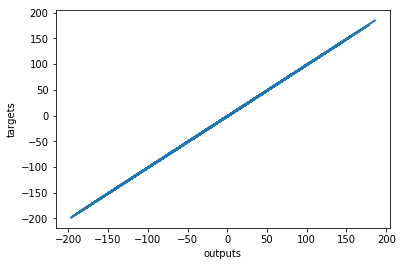

In [12]:
# Wizualizacja jak w zeszycie 1 dla uwidocznienia zależności. Metoda zmienia się nieco ze względu na użycie TF.
# Znowu, normalnie będziemy używać TensorBoard i teraz zwracam to tylko po to, żeby się wizualnie upewnić,
# że to ten sam model. Po co TF? Bo więcej elementów pozostaje tutaj takich samych pomiędzy modelami.
# No i w NumPy bardziej skomplikowane modele to już zdecydowanie więcej kodu...
out = np.squeeze(sess.run([outputs],
               feed_dict = {inputs: training_data['inputs']}))
# Różnicą jest tutaj użycie metody np.squeeze, która pozwala uzyskać odpowiedni format danych.
# Również w wypadku danych wyjściowych, sesja najpierw musi je obliczyć z danych wejściowych,
# co widać po zmiennej out.
tar = np.squeeze(training_data['targets'])
plt.plot(out,tar)
plt.xlabel('outputs')
plt.ylabel('targets')
plt.show()

In [13]:
sess.close()

1. Pobaw się parametrami - np. zmień bazę rekordów (observations) do 100 000 i zobacz co się stanie.

2. Tak jak poprzednio interesującym może być dla Ciebie zmiana prędkości nauki (learning_rate).
   Wypróbuj wartości takie jak 0.0001, 0.001, 0.1, 1 itp.

3. Zmień funkcję celu. Alternatywą dla funkcji L2 przy regresji liniowej jest funkcja Hubera. Ogólnie rzecz biorąc      
jest ona bardziej odpowiednia, gdy w próbce występują przypadki wykraczające znacznie poza skalę (ang. 'outliers'), co w wygenerowanym przez nas zestawie nie miało miejsca, ale w rzeczywiestości się zdarza. Jeśli będziesz mieć do czynienia z takim zestawem może Ci się przydać. Niestety o samej funkcji Hubera dobrego i prostego źródła w polskim internecie nie znalazłem.
Dlaczego Huber do skrajności? Bo Norma L2 podnosi wszystkie różnice "do kwadratu", co daje takim kwiatkom
duży wpływ na wynik, przez co to co nieistotne może wyglądać jak istotne.
Odpowiednią składnią do użycia funkcji celowej Hubera jest: tf.losses.huber_loss(labels, predictions).
Podstawiłem ją na przełączniku w punkcie 4. Przełącznik jest na panelu TensorFlow.

https://pl.wikipedia.org/wiki/Statystyka_odporno%C5%9Bciowa - To jest poniekąd istotne.
Po Angielsku szukaj "Huber Loss" i "Robust Regression" jeśli Cię to interesuje.

Ogólnie jak się tym wszystkim pobawisz i przeanalizujesz, to zauważysz, że dobrze jest używać odpowiedniej funkcji do odpowiednio rozdystrybuowanych danych. Fajnie to wygląda w praktyce. A jak już masz silny sprzęt to już na pewno.